### Parallel Evaluation for Robust Governance

In previous patterns, we relied on a single judgment path even when generating multiple ideas which means that agentic solution was still limited to one evaluative perspective.

<p align="center">
  <img src="../../figures/parallel_eval.png" width="1000">
</p>

The Parallel Evaluation or Multi-Critic Reflection is the architectural pattern where we instead of using a single, monolithic judge …

We create a panel of AI critics. A piece of content is sent to all critics simultaneously, each evaluating it from a unique, expert perspective.
Their parallel feedback is then gathered and synthesized by a final editor agent, which makes a holistic and well-informed decision.

We will build a content review system where a draft is pass to a team of parallel critics before a final editor makes a decision based on their collective feedback.

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [1]:
from pydantic import BaseModel, Field
from typing import Literal


class Critique(BaseModel):
    """A Pydantic model for a structured critique from a single, specialist critic."""
    # A clear, binary decision on whether the content meets this critic's specific criteria.
    is_compliant: bool = Field(description="Whether the content meets the specific criteria of this critic.")
    # Detailed, actionable feedback explaining the decision.
    feedback: str = Field(description="Detailed feedback explaining why the content is or is not compliant. Provide actionable suggestions if non-compliant.")
    

Next, we will define the GraphState, which needs to track the content under review and the critiques from our parallel panel.

In [8]:
from typing import TypedDict, Annotated, Dict, List
from langgraph.graph.message import add_messages

class FinalDecision(BaseModel):
    """The final decision made by the chief editor after reviewing all critiques."""
    decision: Literal["Approve", "Request Revisions", "Reject"] = Field(description="The final verdict for the content.")
    summary_of_feedback: str = Field(description="A summary of all critiques, justifying the final decision.")
    revision_instructions: str = Field(description="If the decision is 'Request Revisions', provide clear, actionable instructions for the author.", default="")

class GraphState(TypedDict):

    content_to_review: str
    # 'critiques' is a dictionary where keys are the critic names and values are their structured Critique objects.
    # The 'lambda' reducer is essential for merging the outputs from the parallel branches.
    critiques: Annotated[Dict[str, Critique], lambda a, b: {**a, **b}]
    final_decision: FinalDecision
    performance_log: Annotated[List[str], add_messages]

In [9]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        model="Qwen/Qwen3-4B-Instruct-2507"
    )
)

### The Fact-Checker's Tool
Our Fact-Checker critic needs a tool to verify claims against the real world. We will use the TavilySearchResults tool for this purpose.

In [7]:
from langchain_community.tools import TavilySearchResults

search_tool = TavilySearchResults(
    max_results=3
)

/var/folders/nm/srw3ygl55jbgpddqwgysqjpm0000gn/T/ipykernel_69773/167871980.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool = TavilySearchResults(


### Defining the Critic & Editor Prompts
Each node in our graph needs a carefully crafted prompt to define its persona and objective.

In [10]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

# This is the prompt for our Fact-Checker Critic, which is special because it uses a tool.
# We don't have a pre-built prompt for it, but will construct a tool-calling agent.

critique_parser = JsonOutputParser(
    name="crtique_parser",
    pydantic_object=Critique
)

synthesize_parser = JsonOutputParser(
    name="synthesize_parser",
    pydantic_object=FinalDecision
)

brand_voice_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a meticulous Brand Voice Analyst. Your sole job is to evaluate a piece of content against the company's brand voice guidelines."
     "Brand Voice Guidelines: We are professional, but approachable. We use clear and concise language. We avoid hype and exaggeration. We are optimistic and focus on customer empowerment."
     "Evaluate the following content based *only* on these guidelines.\n\n{format_instructions}"),
    ("human", "Content to evaluate:\n\n---\n{content_to_review}\n---")
]).partial(format_instructions=critique_parser.get_format_instructions())

risk_assessor_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "You are a cautious Risk Assessor. Your job is to evaluate a piece of content for potential legal, ethical, reputational, or security risks."
     "Look for: promissory language, unsupported claims, sensitive data, controversial topics, and potential for misinterpretation."
     "Evaluate the following content based *only* on these risk criteria.\n\n{format_instructions}"),
    ("human", "Content to evaluate:\n\n---\n{content_to_review}\n---")
]).partial(format_instructions=critique_parser.get_format_instructions())

chief_editor_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are the Chief Editor. You have received feedback on a piece of content from your specialist critics. Your task is to synthesize their feedback, make a final decision (Approve, Request Revisions, or Reject), and provide a clear justification.\n\n{format_instructions}"),
    ("human", "Content under review:\n\n---\n{content_to_review}\n---"
     "\nHere is the feedback from your team:\n\n{critiques}\n\nBased on this, what is your final decision?")
]).partial(format_instructions=synthesize_parser.get_format_instructions())

### Defining the Graph Nodes (The Critics and Editor)
We will define a node for each critic and one for the chief editor. The Fact-Checker node is more complex as it's a mini-agent that can use a tool.

In [ ]:
from langchain import hub
from langchain.agents import create_react_agent, AgentExecutor  
import time

# Pull the ReAct prompt
fact_checker_prompt = hub.pull("hwchase17/react")

# Create agent AND wrap in executor
fact_checker_agent = create_react_agent(llm, [search_tool], fact_checker_prompt)
fact_checker_executor = AgentExecutor(agent=fact_checker_agent, tools=[search_tool])

def fact_checker_node(state: GraphState):
    """An agent that verifies the factual claims in the content."""
    print("--- CRITIC: Fact-Checker is investigating... ---")
    start_time = time.time()
    
    # AgentExecutor uses "input"
    response = fact_checker_executor.invoke({
        "input": f"Verify the factual claims in the following content. Determine if it is compliant (factually accurate) or not, and provide detailed feedback. Content: {state['content_to_review']}"
    })
    
    # Output is in response['output']
    prompt = ChatPromptTemplate.from_messages([
        ("human", "Based on the following analysis, please provide a structured critique: {analysis}\n\n{format_instructions}")
    ]).partial(format_instructions=critique_parser.get_format_instructions())
    
    chain = prompt | llm | critique_parser
    critique = chain.invoke({"analysis": response['output']})
    
    execution_time = time.time() - start_time
    log_entry = f"[FactChecker] Completed in {execution_time:.2f}s."
    print(log_entry)
    
    return {"critiques": {"FactChecker": critique}, "performance_log": [log_entry]}

In [23]:
# testing

content_to_review = "BIG NEWS! Our new QuantumLeap AI processor is 500% faster than any competitor, guaranteed! This will revolutionize the industry. Studies show it cures procrastination. Get yours now!"

inputs = {
    "content_to_review": content_to_review,
    "performance_log": []
}

fact_checker_node(inputs)

--- CRITIC: Fact-Checker is investigating... ---
[FactChecker] Completed in 12.75s.


{'critiques': {'FactChecker': {'is_compliant': False,
   'feedback': "The content is not factually accurate. The claim that the QuantumLeap AI processor is 500% faster than competitors and 'cures procrastination' is unsupported by evidence, misrepresents AI capabilities, and appears to be marketing hyperbole. No credible sources confirm the existence of such a product or its stated performance claims. This makes the content misleading and non-compliant. Actionable suggestions include removing or replacing these unsubstantiated claims with evidence-based statements, citing credible research or independent benchmarks, or clearly labeling such claims as marketing assertions rather than technical facts."}},
 'performance_log': ['[FactChecker] Completed in 12.75s.']}

In [24]:
# Node 2: Brand Voice Analyst
def brand_voice_node(state: GraphState):
    """A critic that evaluates content against brand voice guidelines."""
    print("--- CRITIC: Brand Voice Analyst is reviewing... ---")
    start_time = time.time()
    
    brand_chain = brand_voice_prompt | llm | critique_parser
    critique = brand_chain.invoke({"content_to_review": state['content_to_review']})
    
    execution_time = time.time() - start_time
    log_entry = f"[BrandVoice] Completed in {execution_time:.2f}s."
    print(log_entry)
    
    return {"critiques": {"BrandVoice": critique}, "performance_log": [log_entry]}

In [25]:
# Node 3: Risk Assessor
def risk_assessor_node(state: GraphState):
    """A critic that evaluates content for potential risks."""
    print("--- CRITIC: Risk Assessor is scanning... ---")
    start_time = time.time()
    
    risk_chain = risk_assessor_prompt | llm | critique_parser
    critique = risk_chain.invoke({"content_to_review": state['content_to_review']})
    
    execution_time = time.time() - start_time
    log_entry = f"[RiskAssessor] Completed in {execution_time:.2f}s."
    print(log_entry)
    
    return {"critiques": {"RiskAssessor": critique}, "performance_log": [log_entry]}

In [26]:
# Node 4: Chief Editor (Aggregation & Decision)
def chief_editor_node(state: GraphState):
    """Aggregates critiques and makes a final decision."""
    print("--- EDITOR: Chief Editor is making a decision... ---")
    start_time = time.time()
    
    # Format the critiques for the editor's prompt
    critiques_str = ""
    for critic_name, critique_obj in state['critiques'].items():
        critiques_str += f"- {critic_name} Critique:\n  - Compliant: {critique_obj["is_compliant"]}\n  - Feedback: {critique_obj["feedback"]}\n\n"
    
    editor_chain = chief_editor_prompt | llm | synthesize_parser
    final_decision = editor_chain.invoke({
        "content_to_review": state['content_to_review'],
        "critiques": critiques_str
    })
    
    execution_time = time.time() - start_time
    log_entry = f"[ChiefEditor] Completed in {execution_time:.2f}s."
    print(log_entry)
    
    return {"final_decision": final_decision, "performance_log": [log_entry]}

### Assembling the Graph
This graph has a "fan-out, fan-in" structure. The entry point fans out to all three critic nodes, which run in parallel. After they all complete, their results are automatically aggregated into the critiques dictionary in the state, and the flow converges on the chief_editor node.

In [28]:
from langgraph.graph import StateGraph, END, START

# Initialize a new graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("fact_checker", fact_checker_node)
workflow.add_node("brand_voice_analyst", brand_voice_node)
workflow.add_node("risk_assessor", risk_assessor_node)
workflow.add_node("chief_editor", chief_editor_node)

# Fan out from START to all three critics (parallel execution)
workflow.add_edge(START, "fact_checker")
workflow.add_edge(START, "brand_voice_analyst")
workflow.add_edge(START, "risk_assessor")

# All critics converge to the chief editor
workflow.add_edge("fact_checker", "chief_editor")
workflow.add_edge("brand_voice_analyst", "chief_editor")
workflow.add_edge("risk_assessor", "chief_editor")

# The editor's decision is the final step
workflow.add_edge("chief_editor", END)

# Compile the graph
app = workflow.compile()

print("Graph constructed and compiled successfully.")
print("The content review system is online.")

Graph constructed and compiled successfully.
The content review system is online.


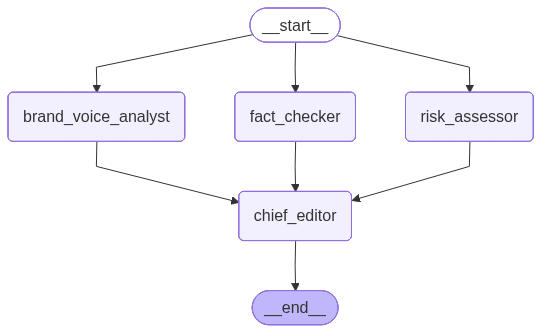

In [29]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### Running and Analyzing the Governance Workflow
Let's test our system with a sample social media post that has a few potential issues.

In [30]:
content_to_review = "BIG NEWS! Our new QuantumLeap AI processor is 500% faster than any competitor, guaranteed! This will revolutionize the industry. Studies show it cures procrastination. Get yours now!"

inputs = {
    "content_to_review": content_to_review,
    "performance_log": []
}

app.invoke(inputs)

--- CRITIC: Brand Voice Analyst is reviewing... ---
--- CRITIC: Fact-Checker is investigating... ---
--- CRITIC: Risk Assessor is scanning... ---
[RiskAssessor] Completed in 2.18s.
[BrandVoice] Completed in 2.46s.
[FactChecker] Completed in 13.05s.
--- EDITOR: Chief Editor is making a decision... ---
[ChiefEditor] Completed in 2.45s.


{'content_to_review': 'BIG NEWS! Our new QuantumLeap AI processor is 500% faster than any competitor, guaranteed! This will revolutionize the industry. Studies show it cures procrastination. Get yours now!',
 'critiques': {'BrandVoice': {'is_compliant': False,
   'feedback': "The content uses excessive hype and exaggeration ('500% faster', 'revolutionize the industry', 'cures procrastination'), which violates the brand voice guideline against exaggeration. It also lacks clarity and customer empowerment, focusing on sensational claims rather than clear, professional, and achievable benefits. Instead, the message should be clear, concise, and focused on genuine customer value without overpromising. Suggest rephrasing to emphasize realistic performance gains, reliability, and tangible benefits for users, while maintaining a professional yet approachable tone."},
  'FactChecker': {'is_compliant': False,
   'feedback': "The content is not compliant with factual accuracy. The claim that the 